#I. Machine Prep

In [1]:
%pip install pandas
!apt install graphviz libgraphviz-dev
%pip install pygraphviz
%pip install powerlaw
%pip install networkx

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 

In [2]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import accuracy_score, auc
import pprint
import numpy as np
from collections import OrderedDict
import powerlaw
import itertools as it
from typing import Dict, Set, Tuple
from scipy.optimize import minimize
import copy
from pprint import pprint

#II. Pedigree Graph Conversion

In [3]:
def pedfile_readin(pedfile):
    cols = ['FamilyID', 'IndividualID', 'PaternalID', 'MaternalID', 'Sex', 'Phenotype', 'Genotype']
    df = pd.read_csv(pedfile, sep=r'\s+', header=None, names=cols)
    return df


def construct_pedigree_graph(df, rm_floaters= True):
    G = nx.DiGraph()

    all_parents_set = set()
    founder_set = set()

    for _, row in df.iterrows():
        # Make sure IndividualID is treated as a string or int consistently if needed
        G.add_node(row['IndividualID'],
                  family=row['FamilyID'],
                  sex=row['Sex'],
                  phenotype=row['Phenotype'])

    for _, row in df.iterrows():
        # Ensure PaternalID and MaternalID are compared to string '0' if they are strings
        paternal_id = row['PaternalID']
        maternal_id = row['MaternalID']
        individual_id = row['IndividualID']

        if paternal_id != 0:
            G.add_edge(paternal_id, individual_id)
            all_parents_set.add(paternal_id)
        if maternal_id != 0:
            G.add_edge(maternal_id, individual_id)
            all_parents_set.add(maternal_id)
        if maternal_id == 0 and paternal_id == 0:
            founder_set.add(individual_id)

    #Removing founders with no children (i.e. floaters)
    if rm_floaters:
        floaters_set = founder_set - all_parents_set
        G.remove_nodes_from(floaters_set)


    return G

###Pedigree Graph Visualization

In [4]:
def plot_pedigree_tree(G, title="Pedigree (Tree Layout)"):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        pos = graphviz_layout(G, prog='dot')  # 'dot' gives top-down DAG style
    except ImportError:
        print("PyGraphviz not installed. Falling back to spring layout.")
        pos = nx.spring_layout(G, seed=42)

    node_colors = ['red' if G.nodes[n]['phenotype'] == 2 else 'lightblue' for n in G.nodes]

    nx.draw(G, pos, with_labels=True, node_color=node_colors, arrows=True)
    plt.title(title)
    plt.show()

#III. Pedigree and Variant Table Simulation

In [5]:
def pedigree_generator(max_children, FamilyID, mode, generation_count, AffectedSpouse= False, BackpropLikelihood= False, alt_freq= 0):
        #-------------------------------------------
        # Helper Functions for Pedigree Propigation
        #-------------------------------------------

        '''
        Basic helper function to add new entry to pedigree dataframe
        '''
        def entry_generator(IndividualID, PaternalID, MaternalID, Sex, Phenotype, Genotype):
            nonlocal family_df
            family_df.loc[IndividualID] = [FamilyID, PaternalID, MaternalID, Sex, Phenotype, Genotype]

        '''
        Helper function to translate between genotype and phenotype
        Dependant on the mode of inheritance
        Input: genotype(int(0,1,2))
        Output: phenotype(int(1,2))
        '''
        def genotype_interpreter(genotype):
            if mode == 'AR':
                phenotype = 2 if genotype == 2 else 1
            if mode == 'AD':
                phenotype = 2 if genotype == 2 or genotype == 1 else 1
            return phenotype

        def calc_inheritance_weights(p,q):

            tt = q**4
            to = 2*p*(q**3)
            tz = (p**2)*(q**2)
            oo = 4*(p**2)*(q**2)
            oz = 2*(p**3)*(q)
            zz = p**4

            homoRef = p**2
            hetero = 2*p*q
            homoAlt = q**2

            inheritance_patterns = {
                'forward_genotypes': {
                #(paternal genotype, maternal genotype) -> [possible child genotypes]
                    (2,2): [2],
                    (2,1): [2,1],
                    (1,2): [2,1],
                    (2,0): [1],
                    (0,2): [1],
                    (1,1): [2,1,0],
                    (0,1): [1,0],
                    (1,0): [1,0],
                    (0,0): [0]
                },
                'forward_weights': {
                    (2,2): [1],
                    (2,1): [1,1],
                    (1,2): [1,1],
                    (2,0): [1],
                    (0,2): [1],
                    (1,1): [1,2,1],
                    (0,1): [1,1],
                    (1,0): [1,1],
                    (0,0): [1]
                },
                #child genotype -> [possible (paternal,maternal) genotypes]
                'reverse_genotypes': {
                    2: [(2,2),(2,1),(1,2),(1,1)],
                    1: [(2,1),(1,2),(2,0),(0,2),(1,1),(1,0),(0,1)],
                    0: [(1,0),(0,1),(0,0)]
                },
                'reverse_weights': {
                    2: [homoAlt**2, homoAlt*hetero, hetero*homoAlt, hetero**2],
                    1: [homoAlt*hetero, hetero*homoAlt, homoAlt*homoRef, homoRef*homoAlt, hetero**2, hetero*homoRef, homoRef*hetero],
                    0: [hetero*homoRef, homoRef*hetero, homoRef**2]
                }
            }

            return inheritance_patterns

        '''
        Wrapper function that generates the primary founder of the pedigree
        By default, this individual is affected
        If AD, 20% chance homozygous, 80% chance heterozygous.
        If AR, 100% chance homozygous.
        Input:
        Output:
        '''
        def primary_founder_generator():
            nonlocal family_df

            if mode == 'AD':
                Genotype = random.choices(population= [1,2],
                                          weights= (0.8, 0.2))[0]
            elif mode == 'AR':
                Genotype= 2

            entry_generator(IndividualID= 1,
                            PaternalID= 0,
                            MaternalID= 0,
                            Sex= random.randint(1,2),
                            Phenotype= 2,
                            Genotype= Genotype)
        '''
        Wrapper function that generates spouses unrelated to primary founder
        Spouse sex dependent on the relative of primary founder.
        Genotype and phenotype dependent on the mode of inheritance and affected spouse paramter.
        Input: relativeID(int)
        Ouput: n/a
        '''
        def spouse_generator(RelativeAnchorID):
            nonlocal family_df, alt_freq, ref_freq

            pp = ref_freq**2
            pq2 = 2*ref_freq*alt_freq
            qq = alt_freq**2

            Sex= 1 if family_df.loc[RelativeAnchorID]['Sex'] == 2 else 2

            if AffectedSpouse:
                Genotype= random.choices(population= [0,1,2],
                                          weights= (pp, pq2, qq),
                                          k=1)[0]

            else:
                Genotype = 0

            entry_generator(IndividualID= len(family_df)+1,
                            PaternalID= 0,
                            MaternalID= 0,
                            Sex= Sex,
                            Phenotype= genotype_interpreter(Genotype),
                            Genotype= Genotype)
        '''
        Wrapper function that generates an entry for the child of two given individuals.
        Child's genotype is chosen from list of allowed gentypes given parents genotypes with equal likelihood.
        Input: PaternalID(int), MaternalID(int)
        Output: n/a
        '''
        def child_generator(PaternalID, MaternalID):
            nonlocal family_df, inheritance_patterns

            parentalGenotype = (int(family_df.loc[PaternalID]['Genotype']), int(family_df.loc[MaternalID]['Genotype']))

            Genotype = random.choices(population= inheritance_patterns['forward_genotypes'][parentalGenotype],
                                      weights= inheritance_patterns['forward_weights'][parentalGenotype],
                                      k=1)[0]

            entry_generator(IndividualID= len(family_df)+1,
                            PaternalID= PaternalID,
                            MaternalID= MaternalID,
                            Sex= random.randint(1,2),
                            Phenotype= genotype_interpreter(Genotype),
                            Genotype= Genotype)
        #---------------------------------------
        # Primary Pedigree Contruction Functions
        #---------------------------------------
        '''
        Function that recursively constructs pedigree in backward direction.
        Infers ancestors of individuals unrelated to primary founder as they are added.
        Input: current_generation(int), RealativeAnchorID(int)
        Output: n/a
        '''
        def recursive_history_backprop(current_generation, RelativeAnchorID):
            nonlocal family_df, generation_count, inheritance_patterns, BackpropLikelihood

            BackpropRNG = random.randint(1,100)/100

            if current_generation > 0 and BackpropRNG <= BackpropLikelihood:

                GenotypeTup = random.choices(population= inheritance_patterns['reverse_genotypes'][family_df.loc[RelativeAnchorID]['Genotype']],
                                                    weights= inheritance_patterns['reverse_weights'][family_df.loc[RelativeAnchorID]['Genotype']],
                                                    k=1)[0]

                ID_list = ['PaternalID', 'MaternalID']

                for i in range(2):
                    entry_generator(IndividualID= len(family_df)+1,
                                    PaternalID= 0,
                                    MaternalID= 0,
                                    Sex= 1 + i,
                                    Phenotype= genotype_interpreter(GenotypeTup[i]),
                                    Genotype= GenotypeTup[i])
                    family_df.at[RelativeAnchorID, ID_list[i]] = len(family_df)
                    recursive_history_backprop(current_generation-1, len(family_df))

        '''
        Function that recursively constructs pedigree in forward direction.
        Input: current_generation(int), RelativeAnchorID(int)
        Output: n/a
        '''
        def recursive_pedigree_construction(current_generation, RelativeAnchorID):
            nonlocal family_df, max_children, generation_count

            if current_generation < generation_count-1:

                spouse_generator(RelativeAnchorID= RelativeAnchorID)

                #Determining Parental Sex for next generation
                if family_df.loc[RelativeAnchorID]['Sex'] == 1:
                    PaternalID = RelativeAnchorID
                    MaternalID = len(family_df)
                else:
                    PaternalID = len(family_df)
                    MaternalID = RelativeAnchorID

                if BackpropLikelihood:
                    recursive_history_backprop(current_generation, len(family_df))

                for child in range(random.randint(1, max_children)):
                    child_generator(PaternalID= PaternalID, MaternalID= MaternalID)
                    recursive_pedigree_construction(current_generation+1, len(family_df))


        #-------------------------------------
        # 1. Construct the empty data frame
        #-------------------------------------
        pedigree_construction_columns = ['FamilyID', 'IndividualID', 'PaternalID', 'MaternalID', 'Sex', 'Phenotype', 'Genotype']
        family_df = pd.DataFrame(columns= pedigree_construction_columns)
        family_df.set_index('IndividualID', inplace=True)

        #-------------------------------------
        # 2. Generating Primary Founder
        #-------------------------------------
        primary_founder_generator()

        #--------------------------------------------
        # 3. Construct Inheritence Pattern Dictionary
        #--------------------------------------------
        ref_freq = 1 - alt_freq
        inheritance_patterns = calc_inheritance_weights(ref_freq, alt_freq)

        #----------------------------------------
        # 4. Generating Pedigree
        #----------------------------------------
        recursive_pedigree_construction(current_generation= 0, RelativeAnchorID= 1)

        #-------------------------------
        # 5. Resetign Standard Indexing
        #-------------------------------
        family_df.reset_index(inplace= True)

        return family_df

In [33]:
def simulate_variant_table(G, mode='AD', n_bg=5, seed=1):
    random.seed(seed)
    samples = list(G.nodes)
    phen = nx.get_node_attributes(G,'phenotype')
    vars = {}
    # causal
    causal = 'chr1:100000_A>T'
    gt = {s:0 for s in samples}
    if mode=='AD':
        for s in samples:
            if phen[s]==2:
                gt[s]=1
        any_aff = [n for n in samples if phen[n]==2][0]
        for p in G.predecessors(any_aff):
            gt[p]=1
    else:
        for s in samples:
            if phen[s]==2:
                gt[s]=2
                for p in G.predecessors(s):
                    gt[p]=1
    vars[causal]=gt
    # background
    for i in range(n_bg):
        vid=f'chr1:{100200+i}_G>C'
        vars[vid]={s:random.choices([0,1,2],[0.8,0.18,0.02])[0] for s in samples}
    return vars

def ped_and_var_table_gen(max_children= 3,
                          FamilyID='Fam',
                          mode='AD',
                          generation_count=3,
                          AffectedSpouse= False,
                          BackpropLikelihood= False,
                          alt_freq= 0,
                          n_bg=5):
    ped_df = pedigree_generator(max_children, FamilyID, mode, generation_count, AffectedSpouse, BackpropLikelihood, alt_freq)
    ped_G = construct_pedigree_graph(ped_df)

    vars_tbl = {}
    gt_dict = {}

    #causal
    causal = 'chr1:100000_A>T'
    for _,row in ped_df.iterrows():
        gt_dict[row['IndividualID']]=row['Genotype']
    vars_tbl[causal] = gt_dict

    #background
    for i in range(n_bg):
        varID= f'chr1:{100200+i}_G>C'
        vars_tbl[varID] = {s:random.choices([0,1,2],[0.8,0.18,0.02])[0] for s in ped_df['IndividualID']}

    return ped_G, vars_tbl


#IV. Pedigree Graph Analysis

###Simple Pedigree Helper Functions

In [8]:
def parents(G, node):
    """Return a list of parent nodes for `node` (incoming edges)."""
    return list(G.predecessors(node))

def siblings(G, node):
    """Return siblings: nodes that share ≥ 1 parent with `node`."""
    sibs = set()
    for p in parents(G, node):
        sibs.update(G.successors(p))
    sibs.discard(node)
    return sibs
def generations(G):
    lvl={}
    Q=[(n,0) for n in G if G.in_degree(n)==0]
    while Q:
        n,d=Q.pop(0)
        if n in lvl: continue
        lvl[n]=d
        for c in G.successors(n): Q.append((c,d+1))
    return lvl

def aff(G):
    return [n for n,d in G.nodes(data='phenotype') if d==2]
def unaff(G):
    return [n for n,d in G.nodes(data='phenotype') if d!=2]


###Pedigree Feature Extraction and Metric Calculation

Pedigree Features
* independent of graph-specific metrics but utilizes graph data structure

In [9]:
def pedigree_features(G):

    phen = nx.get_node_attributes(G,'phenotype')
    aff_nodes = [n for n,p in phen.items() if p==2]
    unaff_nodes = [n for n,p in phen.items() if p!=2]

    # ---------------------------------------------------------------------
    # 1. Ratio Affected Parents
    # ---------------------------------------------------------------------
    aff_aff_parent = 0
    for n in aff_nodes:
        if any(phen.get(p,0)==2 for p in parents(G,n)):
            aff_aff_parent +=1
    ratio_aff_parent = aff_aff_parent/len(aff_nodes) if aff_nodes else 0

    # ---------------------------------------------------------------------
    # 2. Generation Coverage
    # ---------------------------------------------------------------------
    gen = generations(G)
    gens_aff = {gen[n] for n in aff_nodes}
    gen_cov = len(gens_aff)/(max(gen.values())+1) if gen else 0

    # ---------------------------------------------------------------------
    # 3. Affected Sibling Clustering
    # ---------------------------------------------------------------------
    sib_pairs=0; aa_pairs=0
    for n in aff_nodes:
        for sib in siblings(G,n):
            if sib in aff_nodes:
                aa_pairs+=1
            sib_pairs+=1
    sibling_aff_ratio = aa_pairs/sib_pairs if sib_pairs else 0

    # ---------------------------------------------------------------------
    # 4. Betweenness
    # ---------------------------------------------------------------------
    bet = nx.betweenness_centrality(G)
    carrier = [n for n in unaff_nodes if G.nodes[n].get('phenotype')!=2 and G.nodes[n].get('genotype') != 0]
    avg_bet_carrier = np.mean([bet[n] for n in carrier]) if carrier else 0
    avg_bet_unaff = np.mean([bet[n] for n in unaff_nodes]) if unaff_nodes else 0

    #new betweeness of carriers (with graph of only affected and carriers)
    # new_bet = nx.betweenness_centrality(G.subgraph(aff_nodes+carrier))
    # new_avg_bet_carrier = np.mean([new_bet[n] for n in carrier]) if carrier else 0

    features = dict(ratio_aff_parent=ratio_aff_parent, gen_cov=gen_cov, sibling_aff_ratio=sibling_aff_ratio, avg_bet_carrier=avg_bet_carrier, avg_bet_unaff=avg_bet_unaff)

    return features

Initial set of basic graph metrics
* stored within wrapper function

In [10]:
def graph_metrics(G):
    """Return an OrderedDict of network statistics; robust to disconnected graphs."""
    G_u = G.to_undirected()
    metrics = OrderedDict()

    # ---------------------------------------------------------------------
    # 1. Basic Graph Size Metrics
    # ---------------------------------------------------------------------
    metrics['n_nodes']   = G.number_of_nodes()
    metrics['n_edges']   = G.number_of_edges()
    metrics['n_components'] = nx.number_connected_components(G_u)


    # ---------------------------------------------------------------------
    # 2. Centralities (averaged over all nodes)
    # ---------------------------------------------------------------------
    deg_cent  = list(nx.degree_centrality(G_u).values())
    bet_cent  = list(nx.betweenness_centrality(G_u).values())
    clos_cent = list(nx.closeness_centrality(G_u).values())
    metrics['avg_degree_centrality'] = float(np.mean(deg_cent))
    metrics['avg_betweenness']       = float(np.mean(bet_cent))
    metrics['avg_closeness']         = float(np.mean(clos_cent))

    # ---------------------------------------------------------------------
    # 3. Clustering
    # ---------------------------------------------------------------------
    metrics['avg_clustering'] = nx.average_clustering(G_u)

    # ---------------------------------------------------------------------
    # 4. Choosing Core (largest connect component)
    # ---------------------------------------------------------------------
    core = G_u

    # ---------------------------------------------------------------------
    # 5. Diameter and Average Path on Core
    # ---------------------------------------------------------------------
    metrics['diameter'] = nx.diameter(core)
    metrics['avg_path_len'] = nx.average_shortest_path_length(core)

    # ---------------------------------------------------------------------
    # 6. Small-world Sigma (CURRENTLY UNUSED)
    # ---------------------------------------------------------------------
    #opted of plug-and-play sigma calculation from NetworkX over first principals calculation
    #parameters greatly lowered for threshold determination efficiency
    #metrics['sigma_small_world'] = nx.sigma(core, niter= 1, nrand= 1)
    metrics['sigma_small_world'] = 0

    # ---------------------------------------------------------------------
    # 7. Power-law Exponent (Full Graph)
    # ---------------------------------------------------------------------
    # full graph functionality removed with floater culling???
    degs = [d for _, d in G_u.degree()]
    fit = powerlaw.Fit(degs, discrete=True, verbose=False)
    metrics['pl_alpha'] = round(fit.power_law.alpha, 3)
    metrics['pl_xmin']  = fit.power_law.xmin


    return metrics

Additional Graph Metrics
* accssible via summar wrapper function

In [11]:
# ---------------------------------------------------------------------
# 1. Pedigree Width
# ---------------------------------------------------------------------
def pedigree_width(G: nx.DiGraph) -> int:
    if not nx.is_directed_acyclic_graph(G):
        raise ValueError("Graph must be a DAG.")
    #transitive closure creates new graph including all origianl edges and adding edges between all nodes connected by a path
    #i.e. for AD pedigree adds 4 edges connecting both grandparents to both of their grandchildren
    P = nx.algorithms.dag.transitive_closure(G)
    left  = {f"{n}_L" for n in G}
    right = {f"{n}_R" for n in G}
    B = nx.DiGraph()
    B.add_nodes_from(left,  bipartite=0)
    B.add_nodes_from(right, bipartite=1)
    for u, v in P.edges:
        B.add_edge(f"{u}_L", f"{v}_R")
    match = nx.algorithms.bipartite.maximum_matching(B, top_nodes=left)
    matched = len(match) // 2
    return G.number_of_nodes() - matched

# ---------------------------------------------------------------------
# 2. Transitive Reduction Size
# ---------------------------------------------------------------------
# How does transitive reduction work with our pedigrees?
# nx.transitive_reduction only returns a list of duples for edges in transitive reduction
# would only cull child-parent relationships in cases of consanguinity between partent and other child
def transitive_reduction_size(G):
    red = nx.transitive_reduction(G)
    return G.number_of_edges(), red.number_of_edges(), red.number_of_edges()/G.number_of_edges()

# ---------------------------------------------------------------------
# 3. Longest Path Length
# ---------------------------------------------------------------------
def longest_path_length(G):
    return nx.dag_longest_path_length(G)

# ---------------------------------------------------------------------
# 4. Minimal Founder Coverage Set
# ---------------------------------------------------------------------
def minimal_founder_cover_set(G: nx.DiGraph) -> set:
    """
    Return one minimal founder cover (greedy) as a Python set.
    """
    #different founder condition than used in score enhancement (no stipulation on genotype)
    founders = [n for n in G if G.in_degree(n) == 0]
    cover, uncovered = set(), set(G.nodes)
    while uncovered:
        best = max(founders, key=lambda f: len(nx.descendants(G, f) & uncovered) + (f in uncovered))
        cover.add(best)
        uncovered -= nx.descendants(G, best)
        uncovered.discard(best)
    return cover

# ---------------------------------------------------------------------
# 5. Founder Influence
# ---------------------------------------------------------------------
def founder_influence(G) -> Dict[str, float]:
    phen = nx.get_node_attributes(G, "phenotype")
    affected = {n for n, p in phen.items() if p == 2}
    memo_all, memo_aff = {}, {}
    def paths(u, memo, target=None):
        key = (u, id(target))
        if key in memo: return memo[key]
        total = 1 if target is None or u in target else 0
        for v in G.successors(u):
            total += paths(v, memo, target)
        memo[key] = total
        return total
    infl = {}
    for f in (n for n in G if G.in_degree(n)==0):
        all_p = paths(f, memo_all, None)
        aff_p = paths(f, memo_aff, affected)
        infl[f] = aff_p / all_p if all_p else 0
    return infl

# ---------------------------------------------------------------------
# 6. Edge Consistency
# ---------------------------------------------------------------------
# ALREADY INCLUDED STANDARD SEGREGATION SCORING
# consolidate redundancy with standard scoring
def edge_consistency(G, gt, mode="AD"):
    """
    Fraction of parent→child edges whose genotype transition is Mendelian-
    compatible under the specified inheritance mode.
    gt is a dict {node: 0/1/2}.
    """
    ALLOWED_INHERITENCE = {
        'AD': {(0,0):{0}, (1,0):{0,1}, (0,1):{0,1}, (1,1):{0,1,2}, (2,_):{1,2}},
        'AR': {(0,0):{0}, (1,0):{0,1}, (0,1):{0,1}, (1,1):{0,1,2}, (2,_):{1,2}},
    }
    good=0; total=0
    for child in G:
        prnts=parents(G,child)
        gp,gm=[gt.get(p,0) for p in prnts+[0,0]][:2]
        par_gt = (gp,gm) if (gp,gm) in ALLOWED_INHERITENCE[mode] else (gm,gp)
        par_gt = (2,_) if par_gt not in ALLOWED_INHERITENCE[mode] else par_gt
        if gt[child] in ALLOWED_INHERITENCE[mode][par_gt]:
            good+=1
        total+=1
    return good/total

def new_edge_consistency(G, gt, mode="AD"):
    """
    Fraction of parent→child edges whose genotype transition is Mendelian-
    compatible under the specified inheritance mode.
    gt is a dict {node: 0/1/2}.
    """
    #partental genotype (pg,mg) | (mg,pg) --> possible child phenotypes {}
    ALLOWED_PHENO_INHERITENCE = {
        'AD': {(0,0):{1}, (1,0):{1,2}, (1,1):{1,2}, (2,1):{2}, (2,0):{2}, (2,2):{2}},
        'AR': {(0,0):{1}, (1,0):{1}, (1,1):{1,2}, (2,1):{1,2}, (2,0):{1}, (2,2):{2}},
    }
    phen = nx.get_node_attributes(G,'phenotype')
    good=0; total=0
    for child in G:
        prnts=parents(G,child)
        gp,gm=[gt.get(p,0) for p in prnts+[0,0]][:2]
        par_gt = (gp,gm) if (gp,gm) in ALLOWED_PHENO_INHERITENCE[mode] else (gm,gp)
        if phen[child] in ALLOWED_PHENO_INHERITENCE[mode][par_gt]:
            good+=1
        total+=1
    return good/total

# ---------------------------------------------------------------------
# 7. Generation Continuity
# ---------------------------------------------------------------------
def generation_continuity(G, gt, mode="AD"):
    """
    Return the fraction of generations with carriers (by genotype)
    """
    gen = generations(G)
    gens_total = max(gen.values())+1
    alt_gens = {gen[n] for n in G if gt[n]>0}
    if mode=='AD':
        return len(alt_gens)/gens_total
    #Why are we reversing this for AR (wouldnt we also expect this to close to 1 for AR variants as well)???
    #this pattern seems to apply more to phenotype patterns not genotype
    elif mode == 'AR':
        return 1-len(alt_gens)/gens_total

# ---------------------------------------------------------------------
# 8. Carrier Betweeness
# ---------------------------------------------------------------------
def carrier_betweenness(G, gt, phen):
    het_car=[n for n in G if gt[n]==1 and phen[n]!=2]

    if het_car:
        bet = nx.betweenness_centrality(G)
        cb = sum(bet[n] for n in het_car)/len(het_car)
        cb /= max(bet.values()) if bet else 1
        return cb
    else:
        return 0

# ---------------------------------------------------------------------
# 9. One-shot summary (optional helper)
# ---------------------------------------------------------------------
def dag_summary(G: nx.DiGraph) -> dict:
    """
    Return a dict with the most interpretable DAG statistics.
    """
    orig, red, ratio = transitive_reduction_size(G)
    return {
        "edges_original" : orig,
        "edges_reduced"  : red,
        "reduction_ratio": round(ratio, 3),
        "longest_path"   : longest_path_length(G),
        "width"          : pedigree_width(G),
        "founder_cover"  : len(minimal_founder_cover_set(G)),
    }

#V. Mode of Inheritence Classification

###Size-dependent Threshold Determination

In [37]:
def feature_data_generation(generation_count, trials):
    trial_result = {}
    all_trial_feats_df = pd.DataFrame(columns= ['actual_mode', 'ratio_aff_parent', 'gen_cov', 'sibling_aff_ratio', 'avg_bet_carrier', 'avg_bet_unaff', 'new_avg_bet_carrier',
                                                'n_nodes', 'n_edges', 'n_components',
                                                'avg_degree_centrality', 'avg_betweenness', 'avg_closeness',
                                                'avg_clustering', 'diameter', 'avg_path_len',
                                                'sigma_small_world', 'pl_alpha', 'pl_xmin'])
    for test_num in range(1,trials+1):
        famID = 'Fam' + str(test_num)
        actual_mode = random.choices(population= ['AD', 'AR'], weights= [1, 1])[0]
        alt_freq = random.randint(2,10)/100 if actual_mode == 'AD' else random.randint(5,25)/100
        QC_pass = False
        while not QC_pass:
        #generate trial pedigree
            trial_df = pedigree_generator(FamilyID= famID,
                                          mode= actual_mode,
                                          max_children= random.randint(2,5),
                                          generation_count= generation_count,
                                          AffectedSpouse= True,
                                          BackpropLikelihood= random.choice([0.25, 0.5, 0.75]),
                                          alt_freq= alt_freq)

            trial_dg = construct_pedigree_graph(trial_df)
            aff = [n for n in trial_dg.nodes() if trial_dg.nodes[n]['phenotype']==2]
            if len(aff) > 1:
                QC_pass = True


        trial_feat_dict = pedigree_features(trial_dg)
        trial_feat_dict['actual_mode']= actual_mode
        trial_metrics_dict = graph_metrics(trial_dg)
        #union of features dictionary and metrics dictionary
        trial_feat_and_metrics_dict = {**trial_feat_dict, **trial_metrics_dict}
        trial_df = pd.DataFrame(trial_feat_and_metrics_dict, index= [0])

        all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=True)

    return all_trial_feats_df


def roc_param_calc(true_labels, predicted_labels):
    real_pos_count = 0
    real_neg_count = 0
    true_pos_count = 0
    false_pos_count = 0

    for i in range(len(true_labels)):
        if true_labels[i] == 'AD':
            real_pos_count += 1
            if predicted_labels[i] == 'AD':
                true_pos_count += 1
        elif true_labels[i] == 'AR':
            real_neg_count += 1
            if predicted_labels[i] == 'AD':
                false_pos_count += 1


    tpr = true_pos_count/real_pos_count
    fpr = false_pos_count/real_neg_count

    return tpr, fpr

def auc_calc(fpr_list, tpr_list):
    fpr = np.array(fpr_list)
    tpr = np.array(tpr_list)

    sort_indx = np.argsort(fpr)
    fpr = fpr[sort_indx]
    tpr = tpr[sort_indx]

    auc_score = auc(fpr, tpr)

    return auc_score

def param_best_threshold(feature_values, actual_labels):

    #determine range and poarticular thresholds to be tested
    min_value = min(feature_values)
    max_value = max(feature_values)
    thresh_increment = (max_value - min_value)/100
    possible_thresholds = []
    for i in range(102):
        possible_thresholds.append(min_value-thresh_increment + (i*thresh_increment))

    #set defaults for threshold search
    best_threshold = None
    best_accuracy = 0
    direction = None

    tpr_list = []
    fpr_list = []
    #search for best threshold (accounting for greater or less_equal possibilities for classfication relative to AD)
    for threshold in possible_thresholds:
        greater_prediction = ['AD' if value > threshold else 'AR' for value in feature_values]
        less_equal_prediction = ['AD' if value <= threshold else 'AR' for value in feature_values]

        greater_accuracy = accuracy_score(actual_labels, greater_prediction)
        less_equal_accuracy = accuracy_score(actual_labels, less_equal_prediction)


        tpr, fpr = roc_param_calc(actual_labels, greater_prediction)

        tpr_list.append(tpr)
        fpr_list.append(fpr)


        if greater_accuracy > best_accuracy:
            best_accuracy = greater_accuracy
            best_threshold = threshold
            direction = 'greater'

        elif less_equal_accuracy > best_accuracy:
            best_accuracy = less_equal_accuracy
            best_threshold = threshold
            direction = 'less_equal'


    return best_threshold, direction, best_accuracy, tpr_list, fpr_list

def roc_plot(feature, tpr, fpr):
    auc_score = auc_calc(fpr, tpr)

    plt.plot(fpr, tpr, label= f'AUC = {auc_score:.2f}')
    plt.plot([0,1], [0,1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{feature} ROC')
    plt.legend()
    plt.grid(True)
    plt.show()

def multifeature_threshold_determination(feature_df, chosen_features):
    thresholds = {}
    for feature in chosen_features:
        threshold, direction, accuracy, tpr, fpr = param_best_threshold(feature_df[feature].values, feature_df['actual_mode'].values)
        thresholds[feature] = {'threshold': threshold, 'direction': direction, 'accuracy': accuracy}
        #roc_plot(feature, tpr, fpr)
        auc_score = auc_calc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{feature} AUC = {auc_score:.2f}')

    plt.plot([0,1], [0,1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Pedigree Feature ROC')
    plt.legend()
    plt.grid(True)
    plt.show()

    return thresholds

def confidence_score_classification(features, thresholds):
    votes = 0
    total = 0

    for feature, descriptors in thresholds.items():
        threshold = descriptors['threshold']
        direction = descriptors['direction']
        accuracy = descriptors['accuracy']
        feature_value = features[feature]
        total += 1

        if direction == 'greater':
            if feature_value > threshold:
                votes += 1
        elif direction == 'less_equal':
            if feature_value <= threshold:
                votes += 1

    confidence_score = votes/total

    if confidence_score > 0.75:
        return 'AD'
    elif confidence_score < 0.25:
        return 'AR'
    else:
        return 'Uncertain'

def size_specific_threshold_determination(feature_options, trials_count, generation_range):
    min_generation_count = generation_range[0]
    max_generation_count = generation_range[1]
    all_thresholds = {}
    accurate_thresholds = {}
    testing_feature_tables = {}
    for generation_count in range(min_generation_count, max_generation_count+1):
        trial_generated_features = feature_data_generation(generation_count= generation_count,
                                                            trials= trials_count)
        #TRAINING vs TESTING split
        training_features = trial_generated_features.sample(frac=0.8)
        testing_features = trial_generated_features.drop(training_features.index)

        all_size_specific_thresholds = multifeature_threshold_determination(feature_df= training_features,
                                                                            chosen_features= feature_options)

        all_thresholds[generation_count] = all_size_specific_thresholds


        accurate_size_specific_thresholds = {}
        for feature in all_size_specific_thresholds.keys():
            if all_size_specific_thresholds[feature]['accuracy'] >= 0.75:
                accurate_size_specific_thresholds[feature] = all_size_specific_thresholds[feature]

        accurate_thresholds[generation_count] = accurate_size_specific_thresholds

        predicted_mode_field = []
        for _,row in testing_features.iterrows():
            predicted_mode = confidence_score_classification(row, accurate_size_specific_thresholds)
            predicted_mode_field.append(predicted_mode)
        testing_features['predicted_mode'] = predicted_mode_field

        testing_feature_tables[generation_count] = testing_features

        certain_results_df = testing_features[testing_features['predicted_mode']!='Uncertain']
        print('Number of Certain Results: ' + str(len(certain_results_df)) + '/' + str(int(0.2*trials_count)))
        print('Classification Accuracy: ' + str(accuracy_score(certain_results_df['actual_mode'], certain_results_df['predicted_mode'])) + '\n')

    return accurate_thresholds

In [19]:
def get_scaled_thresholds(generation_count,
                          feats_and_mets= ['ratio_aff_parent', 'gen_cov', 'sibling_aff_ratio', 'avg_bet_carrier', 'avg_bet_aff',
                                    #avg_betweenness redundent with avg_bet_carrier?
                                    'avg_degree_centrality', 'avg_betweenness', 'avg_closeness',
                                    'avg_clustering', 'diameter', 'avg_path_len',
                                    'sigma_small_world', 'pl_alpha', 'pl_xmin'],
                          trial_count= 500):
    thresholds = size_specific_threshold_determination(feature_options= feats_and_mets,
                                                       trials_count= trial_count,
                                                       generation_range= (generation_count,generation_count))
    return thresholds[generation_count]


###Threshold-based Classification

In [38]:
def classify_pedigree(PedGraph, thresholds= 0):
    #built in modelign for threshold determination, runs every time you classify a pedigree, not optimal
    all_feats_and_mets = {**pedigree_features(PedGraph), **graph_metrics(PedGraph)}
    if not thresholds:
        thresholds = get_scaled_thresholds(generation_count = max(generations(PedGraph).values())+1,
                                          feats_and_mets= all_feats_and_mets.keys(),
                                          trial_count= 1000)
    predicted_mode = confidence_score_classification(all_feats_and_mets, thresholds)
    print(f'Predicted Mode of Inheritence: {predicted_mode}')
    return predicted_mode



#VI. Segregation Scoring

In [15]:
def segregation_network_score(G, gt, mode='AD', w_edge=.6,w_gen=.2,w_bet=.2):

    # edge score does not depend on mode??? gt inheritenc patter is the same regardless
    # shouldn't all variants follow mendelian pattern barring mutational event
    # made new edge consistency that looks at parental genotype and child phenotype pairings
    edge_score= edge_consistency(G,gt,mode)

    # generation continuity
    gen_score= generation_continuity(G,gt,mode)
    gen_score= max(0,min(1,gen_score)) #ensures genscore within [0,1]

    # carrier betweenness
    phen = nx.get_node_attributes(G,'phenotype')
    cb = carrier_betweenness(G, gt, phen)
    if cb:
        bet_score= cb if mode=='AR' else 1-cb
    else:
        bet_score= 0 if mode=='AR' else 1

    return w_edge*edge_score+w_gen*gen_score+w_bet*bet_score

def scan_variants(G, vars_dict, weights, mode='AD'):
    # mode= classify_pedigree(G)
    w_edge, w_gen, w_bet = weights
    scores={vid: segregation_network_score(G,gt,mode,w_edge, w_gen, w_bet) for vid,gt in vars_dict.items()}
    best=max(scores,key=scores.get)
    return best, scores


###Trial Data Setup

Manual Data Generation

In [16]:
ped_AD = '''\
FAM1 1 0 0 1 2
FAM1 2 0 0 2 1
FAM1 3 1 2 1 2
FAM1 4 1 2 2 1
FAM1 5 0 0 2 1
FAM1 6 3 5 1 2
FAM1 7 3 5 2 1
FAM1 8 0 0 1 1
'''
open('ad_complete.ped','w').write(ped_AD)


ped_AR = '''\
FAM2 1 0 0 1 1
FAM2 2 0 0 2 1
FAM2 3 1 2 1 1
FAM2 4 1 2 2 1
FAM2 10 0 0 1 1
FAM2 11 0 0 2 1
FAM2 5 3 11 1 2
FAM2 6 3 11 2 1
FAM2 7 4 10 2 2
FAM2 8 4 10 1 1
'''
open('ar_complete.ped','w').write(ped_AR)

DF_ad = pedfile_readin('ad_complete.ped')
DF_ar = pedfile_readin('ar_complete.ped')
G_ad = construct_pedigree_graph(DF_ad)
G_ar = construct_pedigree_graph(DF_ar)

In [18]:
vars_AD = simulate_variant_table(G_ad, 'AD')
vars_AR = simulate_variant_table(G_ar, 'AR')

Automated Data Generation

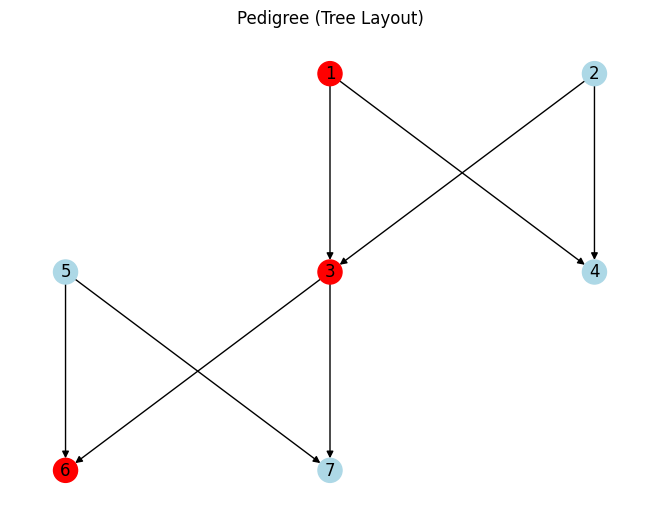

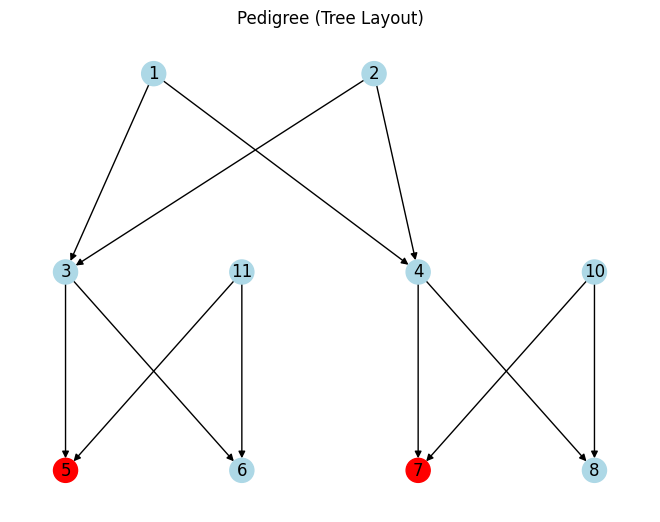

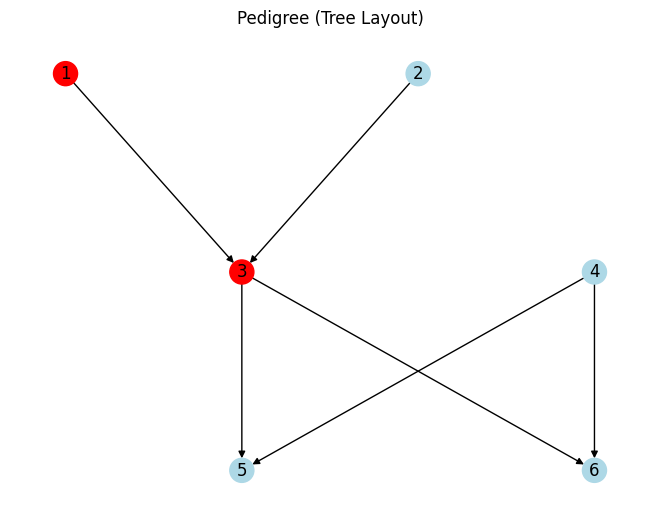

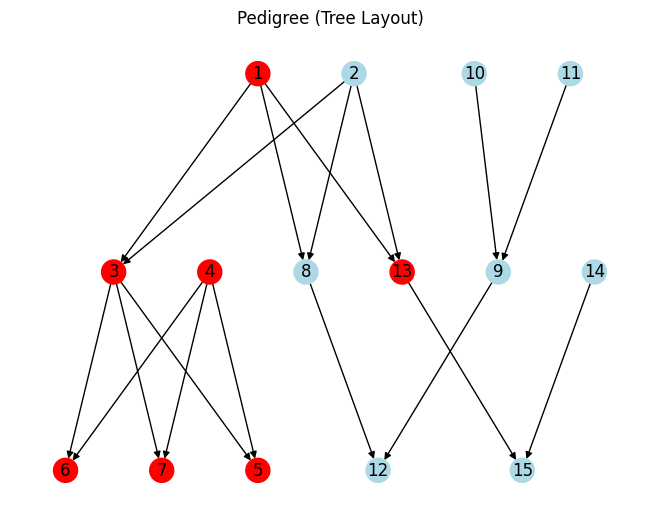

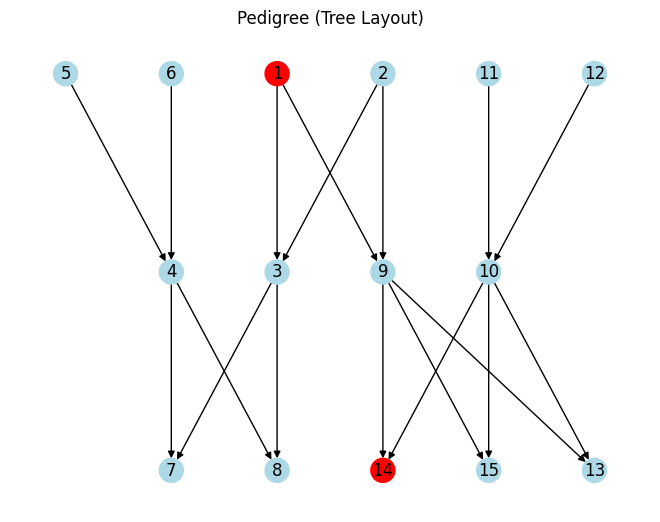

In [36]:
family_num = 10
all_fam_data = {}
all_fam_data['FAM1']= {'PedGraph': G_ad, 'VarTable': vars_AD}
all_fam_data['FAM2']= {'PedGraph': G_ar, 'VarTable': vars_AR}
for family in range(family_num):
    FamilyID = f'FAM{family+3}'
    mode= random.choice(['AD','AR'])
    alt_freq = random.randint(2,10)/100 if mode == 'AD' else random.randint(5,25)/100
    QC_pass = False
    while not QC_pass:
        G,V = ped_and_var_table_gen(FamilyID= FamilyID,
                                    mode= mode,
                                    max_children= 3,
                                    generation_count= 3,
                                    AffectedSpouse= True,
                                    BackpropLikelihood= 0.5,
                                    alt_freq= alt_freq,
                                    n_bg= 5)
        #redoing ped generation for sufficiently small or spares pedigrees
        aff = [n for n in G.nodes() if G.nodes[n]['phenotype']==2]
        if G.number_of_nodes() > 5 and len(aff) > 1:
            QC_pass = True

    all_fam_data[FamilyID] = {'PedGraph': G, 'VarTable': V}
for i in range(5):
    plot_pedigree_tree(all_fam_data['FAM'+str(i+1)]['PedGraph'])

###Trial Scoring

**Notes:**
*   Removing floaters helped increase differentiation in AD raw score rankings



/tmp/ipython-input-12-2104894476.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=True)
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

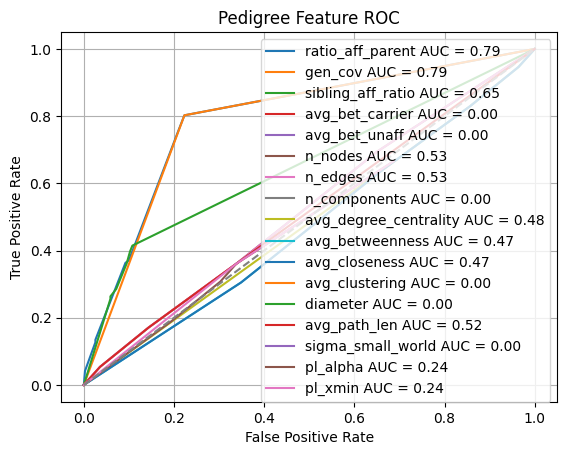

Number of Certain Results: 200/200
Classification Accuracy: 0.785

Predicted Mode of Inheritence: AD


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
/tmp/ipython-input-12-2104894476.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=True)
/tmp/ipython-input-12-2104894476.py:30: FutureWarning: The behavior of 

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan


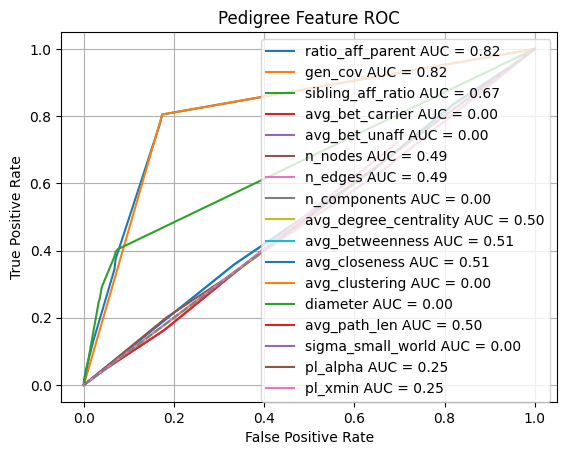

Number of Certain Results: 200/200
Classification Accuracy: 0.81

Predicted Mode of Inheritence: AR
AD ranking:


,Variant,Score
0,chr1:100000_A>T,0.914286
3,chr1:100202_G>C,0.828571
1,chr1:100200_G>C,0.814286
2,chr1:100201_G>C,0.814286
4,chr1:100203_G>C,0.814286
5,chr1:100204_G>C,0.800000


AR ranking:


,Variant,Score
3,chr1:100202_G>C,0.84
1,chr1:100200_G>C,0.64
4,chr1:100203_G>C,0.64
0,chr1:100000_A>T,0.46
2,chr1:100201_G>C,0.42
5,chr1:100204_G>C,0.24


In [21]:
_, raw_AD_scores = scan_variants(G_ad, vars_AD, (0.6, 0.2, 0.2), mode=classify_pedigree(G_ad))
_, raw_AR_scores = scan_variants(G_ar, vars_AR, (0.6, 0.2, 0.2), mode=classify_pedigree(G_ar))
var_df_AD = pd.DataFrame(list(raw_AD_scores.items()), columns=['Variant','Score']).sort_values('Score', ascending=False)
var_df_AR = pd.DataFrame(list(raw_AR_scores.items()), columns=['Variant','Score']).sort_values('Score', ascending=False)
print('AD ranking:')
display(var_df_AD)
print('AR ranking:')
display(var_df_AR)

###Trial Scoring with Weight Optimization

In [111]:
def weight_opt_objective(weights, G, linked_variant, vars_dict, mode):
    w_edge, w_gen, w_bet = weights
    linked_score = segregation_network_score(G= G,
                                             gt= vars_dict[linked_variant],
                                             mode= mode,
                                             w_edge= w_edge,
                                             w_gen= w_gen,
                                             w_bet= w_bet)
    max_unlinked_score = max(segregation_network_score(G= G,
                                                       gt= gt,
                                                       mode= mode,
                                                       w_edge= w_edge,
                                                       w_gen= w_gen,
                                                       w_bet= w_bet) for VarID,gt in vars_dict.items() if VarID != linked_variant)
    return 1- (linked_score - max_unlinked_score)




def weights_optimization(G, vars_dict, linked_variant, mode= 'AD'):
    bounds = [(0.1,1),(0.1,1),(0.1,1)]
    constraints = {'type': 'eq',
                  #figure out how this function is working
                  'fun': lambda w: np.sum(w)-1}
    initial_guess = np.array([1/3, 1/3, 1/3])
    mode= classify_pedigree(G)
    results = minimize(fun= weight_opt_objective,
                                  x0= initial_guess,
                                  args= (G, linked_variant, vars_dict, mode),
                                  bounds= bounds,
                                  constraints= constraints)
    return results.x


/tmp/ipython-input-12-2104894476.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=True)
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

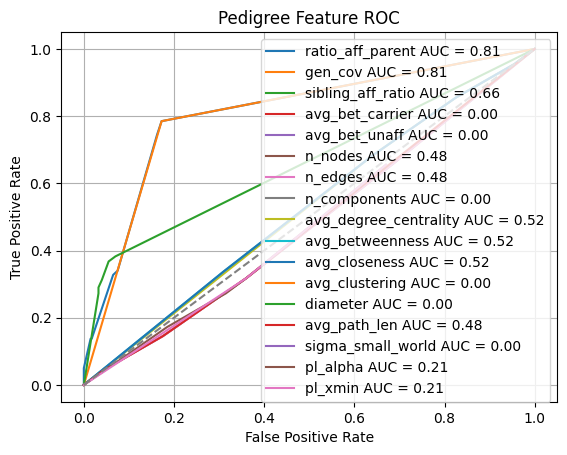

Number of Certain Results: 200/200
Classification Accuracy: 0.84

Predicted Mode of Inheritence: AD


/tmp/ipython-input-12-2104894476.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=True)
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan


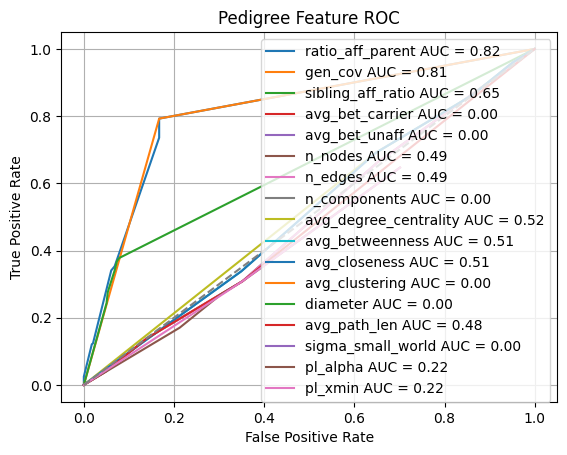

Number of Certain Results: 200/200
Classification Accuracy: 0.8

Predicted Mode of Inheritence: AD


/tmp/ipython-input-12-2104894476.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=True)
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

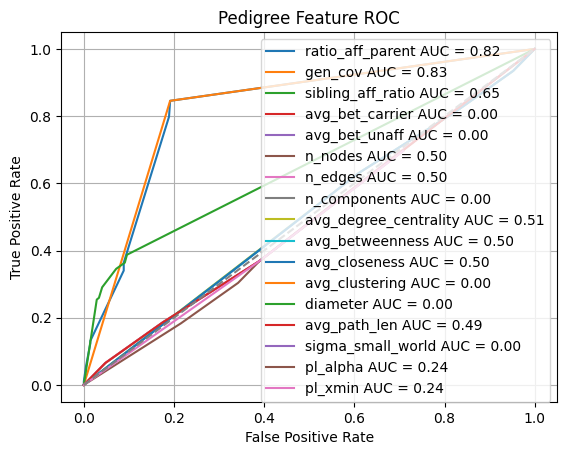

Number of Certain Results: 200/200
Classification Accuracy: 0.825

Predicted Mode of Inheritence: AR


/tmp/ipython-input-12-2104894476.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=True)
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (sel

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1156: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/usr/local/lib/python3.11/dist-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Retu

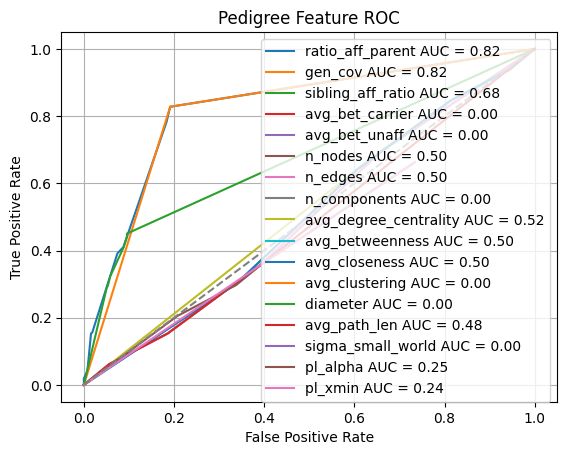

Number of Certain Results: 200/200
Classification Accuracy: 0.815

Predicted Mode of Inheritence: AR
[0.699996 0.200004 0.1     ]
AD ranking:


,Variant,Score
0,chr1:100000_A>T,0.900001
3,chr1:100202_G>C,0.800001
1,chr1:100200_G>C,0.799999
2,chr1:100201_G>C,0.799999
4,chr1:100203_G>C,0.799999
5,chr1:100204_G>C,0.799996


[0.8 0.1 0.1]
AR ranking:


,Variant,Score
1,chr1:100200_G>C,0.87
4,chr1:100203_G>C,0.87
3,chr1:100202_G>C,0.77
2,chr1:100201_G>C,0.76
0,chr1:100000_A>T,0.63
5,chr1:100204_G>C,0.52


In [113]:
optimized_AD_weights = weights_optimization(G_ad, vars_AD, linked_variant='chr1:100000_A>T', mode=classify_pedigree(G_ad))
_, optimized_AD_scores = scan_variants(G_ad, vars_AD, optimized_AD_weights)
optimized_AR_weights = weights_optimization(G_ar, vars_AR, linked_variant='chr1:100000_A>T', mode=classify_pedigree(G_ar))
_, optimized_AR_scores = scan_variants(G_ar, vars_AR, optimized_AR_weights)
print(optimized_AD_weights)
opt_var_df_AD = pd.DataFrame(list(optimized_AD_scores.items()), columns=['Variant','Score']).sort_values('Score', ascending=False)
print('AD ranking:')
display(opt_var_df_AD)
print(optimized_AR_weights)
opt_var_df_AR = pd.DataFrame(list(optimized_AR_scores.items()), columns=['Variant','Score']).sort_values('Score', ascending=False)
print('AR ranking:')
display(opt_var_df_AR)

#VII. Enhanced Segregation Scoring

In [22]:
def dag_enhanced_score(G, gt, base_S, mode="AD"):
    # ------------------------------------------------------------------
    # 1. founder influence boost
    # ------------------------------------------------------------------
    founders = [n for n in G if G.in_degree(n)==0 and gt[n]>0]
    if founders:
        fi = founder_influence(G)
        boost = sum(fi[f] for f in founders) / len(founders)
        base_S *= 0.8 + 0.2*boost   # boost ≤ +20 %

    # ------------------------------------------------------------------
    # 2. redundancy penalty via transitive reduction edge-consistency
    # ------------------------------------------------------------------
    G_red = nx.transitive_reduction(G)
    E_red = edge_consistency(G_red, gt, mode)
    #if G_red is unchanged from original, what does this do to our score
    #amplifies redundancy penalty
    base_S = min(base_S, 0.5*base_S + 0.5*E_red)

    # ------------------------------------------------------------------
    # 3. depth vs allele depth
    # ------------------------------------------------------------------
    depth = longest_path_length(G)
    alt_nodes = [n for n in G if gt[n]>0]
    alt_depth = 0
    if depth and founders and alt_nodes:
        # shortest founder→alt path for each pair that is connected
        lengths = []
        for f in founders:
            for a in alt_nodes:
                if nx.has_path(G, f, a):
                    lengths.append(nx.shortest_path_length(G, f, a))
        if lengths:
            alt_depth = max(lengths)
    if depth:
        base_S *= 0.9 + 0.1*(alt_depth / depth)

    # ------------------------------------------------------------------
    # 4. width adjustment (down-weight very wide pedigrees)
    # ------------------------------------------------------------------
    width = pedigree_width(G)
    base_S /= max(1, width / 4)   # 4 = median width in our toy data

    # ------------------------------------------------------------------
    # 5. minimal-founder cover filter (only if all carriers outside cover)
    # ------------------------------------------------------------------
    cover = minimal_founder_cover_set(G)
    if founders and not any(f in cover for f in founders):
        base_S *= 0.5             # soft penalty instead of hard −1

    return round(base_S, 3)

    # ------------------------------------------------------------------
    # 5. minimal-founder cover filter (only if all carriers outside cover)
    # ------------------------------------------------------------------
def run_dag_scan(G, variants, scores_base, mode="AD"):
    out = []
    for vid, gt in variants.items():
        base_S = scores_base[vid]          # from previous scan
        full_S = dag_enhanced_score(G, gt, base_S, mode)
        out.append((vid, base_S, full_S))
    return pd.DataFrame(out, columns=["Variant","S_base","S_DAG"]).sort_values("S_DAG", ascending=False)

In [23]:
print("=== AD pedigree ===")
res_AD = run_dag_scan(G_ad, vars_AD, raw_AD_scores, mode="AD")
display(res_AD.head())

print("=== Optimized AD pedigree ===")
res_opt_AD = run_dag_scan(G_ad, vars_AD, optimized_AD_scores, mode="AD")
display(res_opt_AD.head())

print("=== AR pedigree ===")
res_AR = run_dag_scan(G_ar, vars_AR, raw_AR_scores, mode="AR")
display(res_AR.head())

print("=== Optimized AR pedigree ===")
res_opt_AR = run_dag_scan(G_ar, vars_AR, optimized_AR_scores, mode="AR")
display(res_opt_AR.head())

=== AD pedigree ===


,Variant,S_base,S_DAG
0,chr1:100000_A>T,0.914286,0.841
2,chr1:100201_G>C,0.814286,0.733
5,chr1:100204_G>C,0.800000,0.720
1,chr1:100200_G>C,0.814286,0.645
3,chr1:100202_G>C,0.828571,0.645


=== Optimized AD pedigree ===


,Variant,S_base,S_DAG
0,chr1:100000_A>T,0.900001,0.828
2,chr1:100201_G>C,0.799999,0.720
5,chr1:100204_G>C,0.799996,0.720
1,chr1:100200_G>C,0.799999,0.634
4,chr1:100203_G>C,0.799999,0.634


=== AR pedigree ===


,Variant,S_base,S_DAG
3,chr1:100202_G>C,0.84,0.756
4,chr1:100203_G>C,0.64,0.576
1,chr1:100200_G>C,0.64,0.494
0,chr1:100000_A>T,0.46,0.379
2,chr1:100201_G>C,0.42,0.360


=== Optimized AR pedigree ===


,Variant,S_base,S_DAG
3,chr1:100202_G>C,0.94,0.828
0,chr1:100000_A>T,0.46,0.379
4,chr1:100203_G>C,0.14,0.126
1,chr1:100200_G>C,0.14,0.108
2,chr1:100201_G>C,0.07,0.060


#Testbed

Transverse Reduction

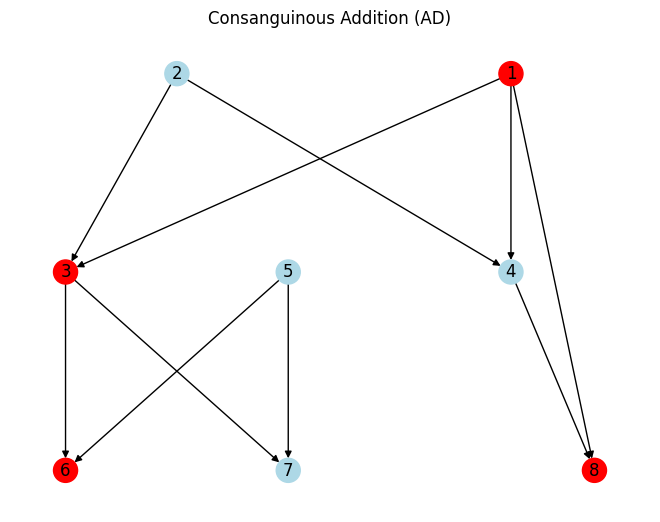

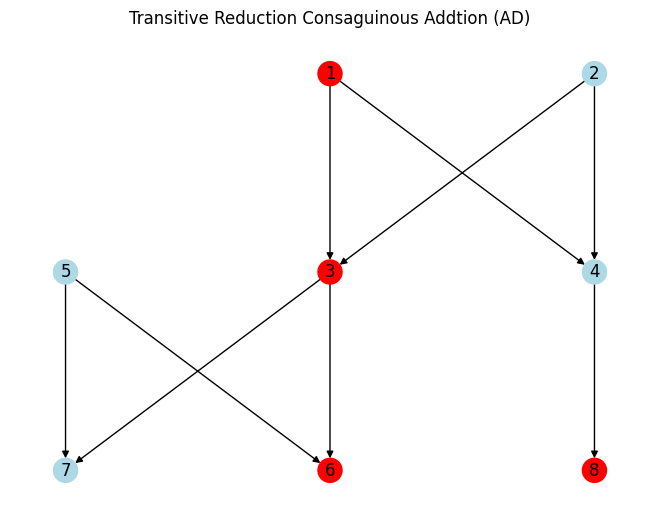

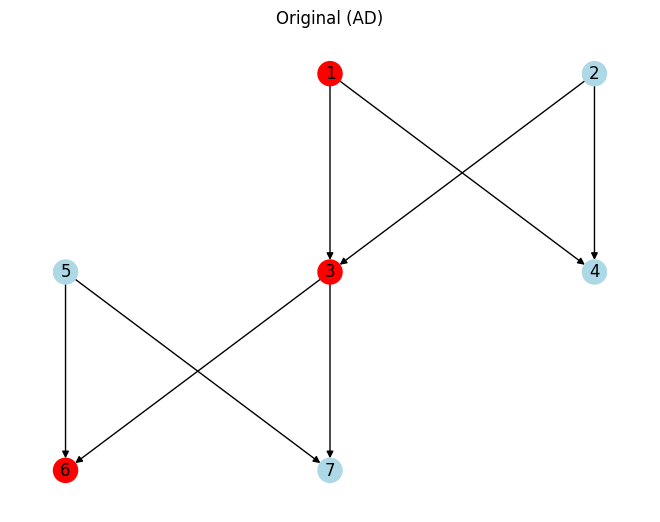

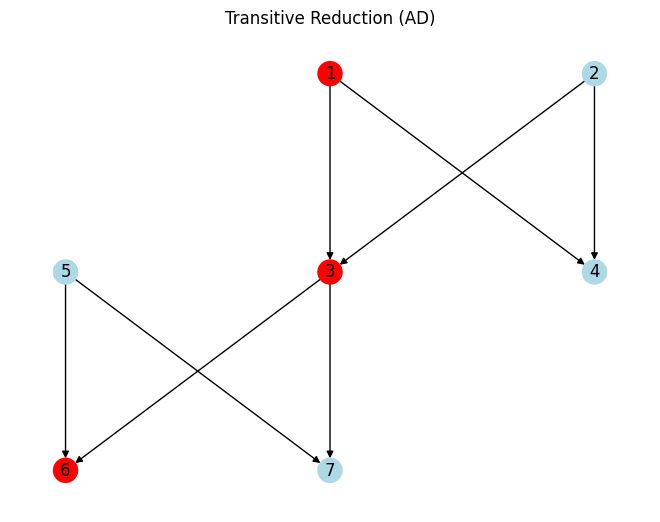

{'edges_original': 8,
 'edges_reduced': 8,
 'founder_cover': 3,
 'longest_path': 2,
 'reduction_ratio': 1.0,
 'width': 3}


In [43]:
testG_AD = copy.deepcopy(G_ad)
testG_AD.add_node(8, family='FAM1', sex=1, phenotype=2)
testG_AD.add_edge(1, 8)
testG_AD.add_edge(4, 8)

test_trG_AD = nx.transitive_reduction(testG_AD)
test_trG_AD.add_nodes_from(testG_AD.nodes(data=True))
test_trG_AD.add_edges_from((u, v, testG_AD.edges[u,v]) for u, v in test_trG_AD.edges)

plot_pedigree_tree(testG_AD, title="Consanguinous Addition (AD)")
plot_pedigree_tree(test_trG_AD, title="Transitive Reduction Consaguinous Addtion (AD)")


trG_AD = nx.transitive_reduction(G_ad)
trG_AD.add_nodes_from(G_ad.nodes(data=True))
trG_AD.add_edges_from((u, v, G_ad.edges[u,v]) for u, v in trG_AD.edges)

plot_pedigree_tree(G_ad, title="Original (AD)")
plot_pedigree_tree(trG_AD, title="Transitive Reduction (AD)")

pprint(dag_summary(G_ad))